<a href="https://colab.research.google.com/github/chaitanya-949/forecasting-electricity-prices/blob/main/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Liabraries

In [ ]:
import pandas as pd  # Pandas is used for data manipulation and analysis.
import numpy as np  # Numpy is used for numerical operations, especially with arrays.
import matplotlib.pyplot as plt  # Matplotlib for plotting graphs.
import seaborn as sns  # Seaborn for statistical data visualization, built on top of matplotlib.
%matplotlib inline
import tensorflow as tf  # TensorFlow is used for building and training deep learning models.

import warnings  # Used to manage warnings in the code.
from tensorflow.keras.layers import Dense, LSTM ,Dropout # Importing Dense and LSTM layers from Keras to build the LSTM model.

from sklearn.metrics import mean_squared_error, r2_score  # Metrics for evaluating the model's performance (MSE, R-squared).
from sklearn.preprocessing import MinMaxScaler  # Used to scale/normalize the data to a specific range (for example, 0 to 1).
from sklearn.decomposition import PCA  # Principal Component Analysis for dimensionality reduction.
from sklearn.model_selection import train_test_split  # Splitting the dataset into training and testing sets.
from math import sqrt  # Used to calculate the square root (e.g., for RMSE calculations).

# Ignore future warnings and user warnings to keep the output clean
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))

In [ ]:
# Read the datasets

df_weather = pd.read_csv("/content/weather_features.csv",parse_dates=['dt_iso'])# weather data_set

df_energy = pd.read_csv("/content/energy_dataset.csv", parse_dates=['time']) #energy data_set

# Energy Dataset

# Dataset First View

In [ ]:
#csv view
df_energy.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


# Dataset Rows & Columns count

In [ ]:
#shape of the dataframe(rows,columns)
df_energy.shape

(35064, 29)

# Dataset Information

In [ ]:
# Dataset Info
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

In [ ]:

# Convert time to datetime object and set it as index

df_energy['time'] = pd.to_datetime(df_energy['time'], utc=True, infer_datetime_format=True)
#df_energy = df_energy.set_index('time')

# Nan's And Duplicates count

In [ ]:
# Find NaNs and duplicates in df_energy

print(df_energy.isnull().values.sum())

print(df_energy.duplicated().sum())



70529
0


In [ ]:
# Find the number of NaNs in each column

df_energy.isnull().sum(axis=0)

,0
time,0
generation biomass,19
generation fossil brown coal/lignite,18
generation fossil coal-derived gas,18
generation fossil gas,18
generation fossil hard coal,18
generation fossil oil,19
generation fossil oil shale,18
generation fossil peat,18
generation geothermal,18


# Data Vizualisation

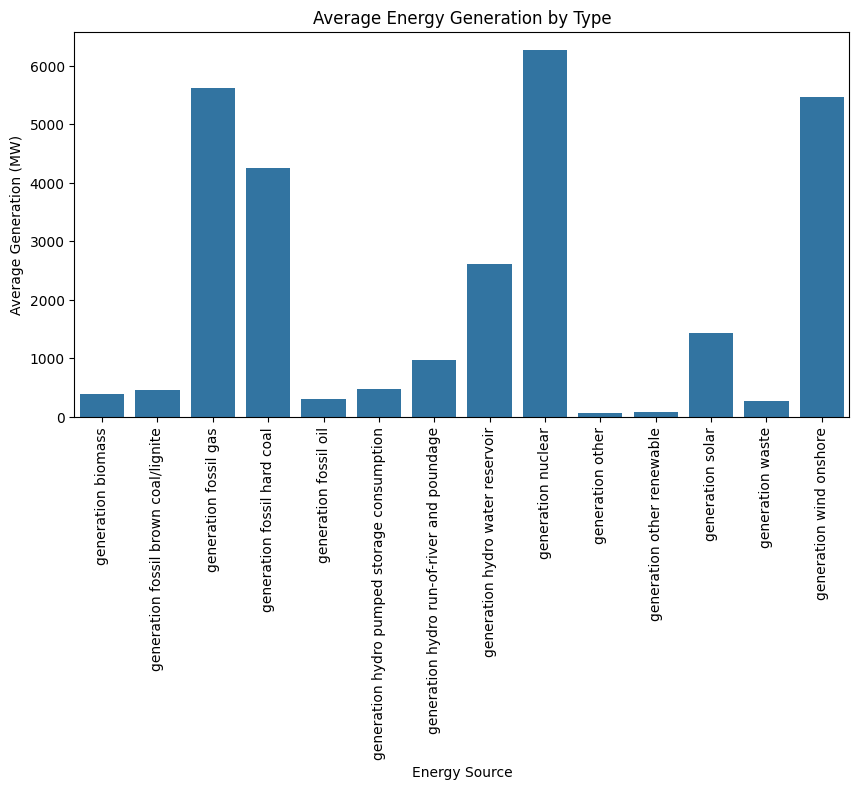

In [ ]:
# Calculate average generation for selected energy sources
avg_generation = df_energy[['generation biomass', 'generation fossil brown coal/lignite',
        'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste','generation wind onshore']].mean()

plt.figure(figsize=(10,5))
sns.barplot(x=avg_generation.index, y=avg_generation.values)
plt.xlabel('Energy Source')
plt.ylabel('Average Generation (MW)')
plt.title('Average Energy Generation by Type')
plt.xticks(rotation=90)
plt.show()


<Figure size 1000x500 with 0 Axes>

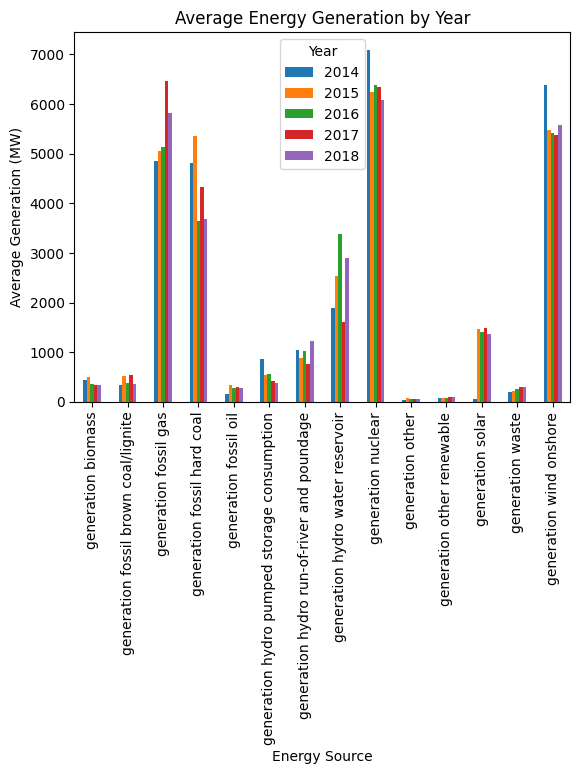

In [ ]:
#Extracting year column to see Average Energy Generation by Year
df_energy['year'] = pd.to_datetime(df_energy['time']).dt.year

# Group by year and calculate the average generation for each year
avg_generation_by_year = df_energy.groupby('year')[['generation biomass', 'generation fossil brown coal/lignite',
        'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste','generation wind onshore']].mean()

# Transpose the dataframe for plotting
avg_generation_by_year = avg_generation_by_year.transpose()

# Plot the average generation for each year in a bar plot
plt.figure(figsize=(10,5))
avg_generation_by_year.plot(kind='bar')
plt.xlabel('Energy Source')
plt.ylabel('Average Generation (MW)')
plt.title('Average Energy Generation by Year')
plt.xticks(rotation=90)
plt.legend(title='Year')
plt.show()


In [ ]:
df_energy.set_index('time', inplace=True)
df_energy.drop("year",axis=1,inplace=True)

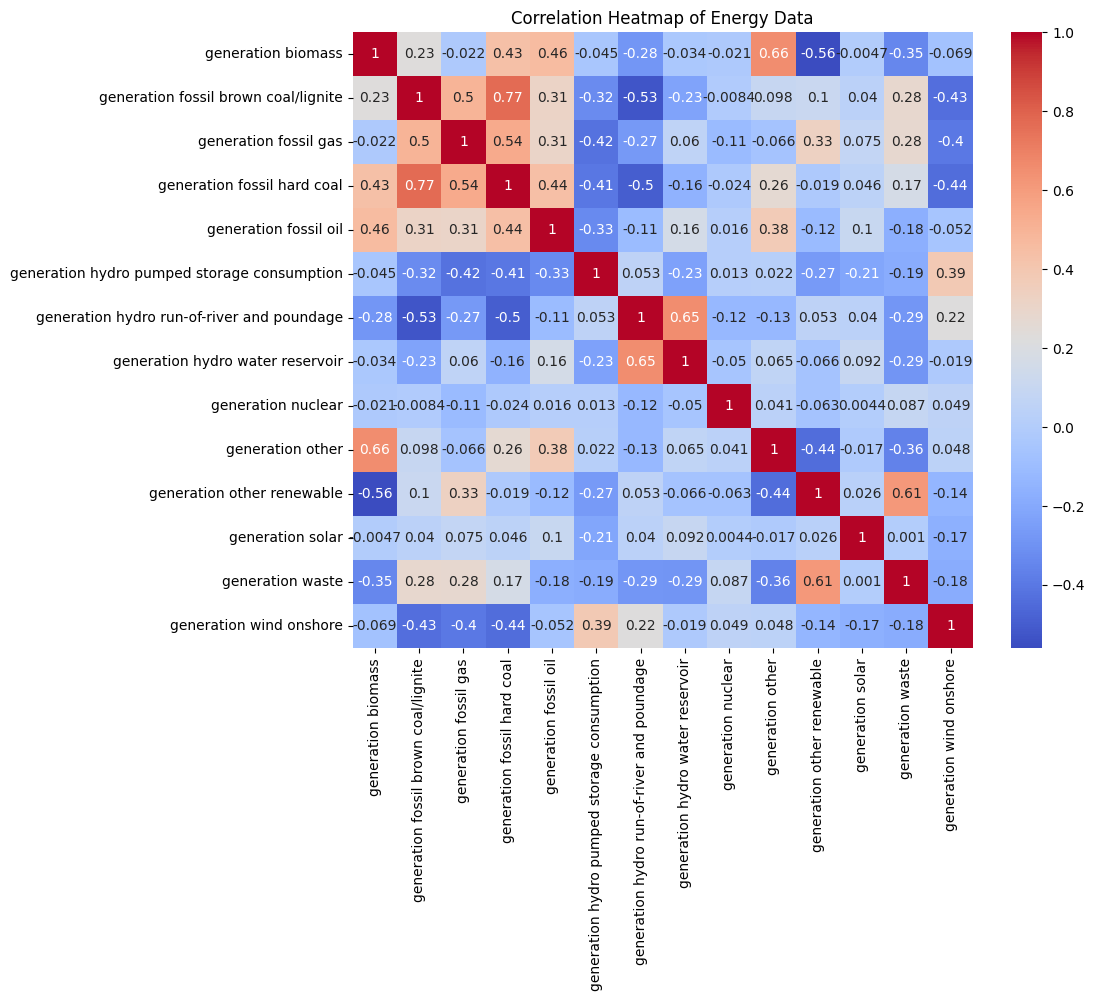

In [ ]:
plt.figure(figsize=(10,8))
corr = df_energy[['generation biomass', 'generation fossil brown coal/lignite',
        'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste','generation wind onshore']].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Energy Data')
plt.show()


In [ ]:
# Drop unusable columns

df_energy = df_energy.drop(['generation fossil coal-derived gas','generation fossil oil shale',
                            'generation fossil peat', 'generation geothermal',
                            'generation hydro pumped storage aggregated', 'generation marine',
                            'generation wind offshore', 'forecast wind offshore eday ahead',
                            'total load forecast', 'forecast solar day ahead',
                            'forecast wind onshore day ahead'],
                            axis=1)

In [ ]:
# Fill null values using interpolation

df_energy.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

##weather_dataset


In [ ]:
df_weather.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [ ]:
df_weather.shape

(178396, 17)

In [ ]:
# Print the type of each variable in df_weather

df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178396 non-null  object 
 1   city_name            178396 non-null  object 
 2   temp                 178396 non-null  float64
 3   temp_min             178396 non-null  float64
 4   temp_max             178396 non-null  float64
 5   pressure             178396 non-null  int64  
 6   humidity             178396 non-null  int64  
 7   wind_speed           178396 non-null  int64  
 8   wind_deg             178396 non-null  int64  
 9   rain_1h              178396 non-null  float64
 10  rain_3h              178396 non-null  float64
 11  snow_3h              178396 non-null  float64
 12  clouds_all           178396 non-null  int64  
 13  weather_id           178396 non-null  int64  
 14  weather_main         178396 non-null  object 
 15  weather_descripti

In [ ]:
def df_convert_dtypes(df, convert_from, convert_to):
    cols = df.select_dtypes(include=[convert_from]).columns
    for col in cols:
        df[col] = df[col].values.astype(convert_to)
    return df

In [ ]:
# Convert columns with int64 type values to float64 type

df_weather = df_convert_dtypes(df_weather, np.int64, np.float64)

In [ ]:
# Convert dt_iso to datetime type, rename it and set it as index

df_weather['time'] = pd.to_datetime(df_weather['dt_iso'], utc=True, infer_datetime_format=True)
df_weather = df_weather.drop(['dt_iso'], axis=1)
df_weather = df_weather.set_index('time')

In [ ]:
df_weather.describe().T

,count,mean,std,min,25%,50%,75%,max
temp,178396.0,289.618605,8.026199,262.24,283.670000,289.15,295.150000,315.600
temp_min,178396.0,288.330442,7.955491,262.24,282.483602,288.15,293.730125,315.150
temp_max,178396.0,291.091267,8.612454,262.24,284.650000,290.15,297.150000,321.150
pressure,178396.0,1069.260740,5969.631893,0.00,1013.000000,1018.00,1022.000000,1008371.000
humidity,178396.0,68.423457,21.902888,0.00,53.000000,72.00,87.000000,100.000
wind_speed,178396.0,2.470560,2.095910,0.00,1.000000,2.00,4.000000,133.000
wind_deg,178396.0,166.591190,116.611927,0.00,55.000000,177.00,270.000000,360.000
rain_1h,178396.0,0.075492,0.398847,0.00,0.000000,0.00,0.000000,12.000
rain_3h,178396.0,0.000380,0.007288,0.00,0.000000,0.00,0.000000,2.315
snow_3h,178396.0,0.004763,0.222604,0.00,0.000000,0.00,0.000000,21.500


#Data vizualisation

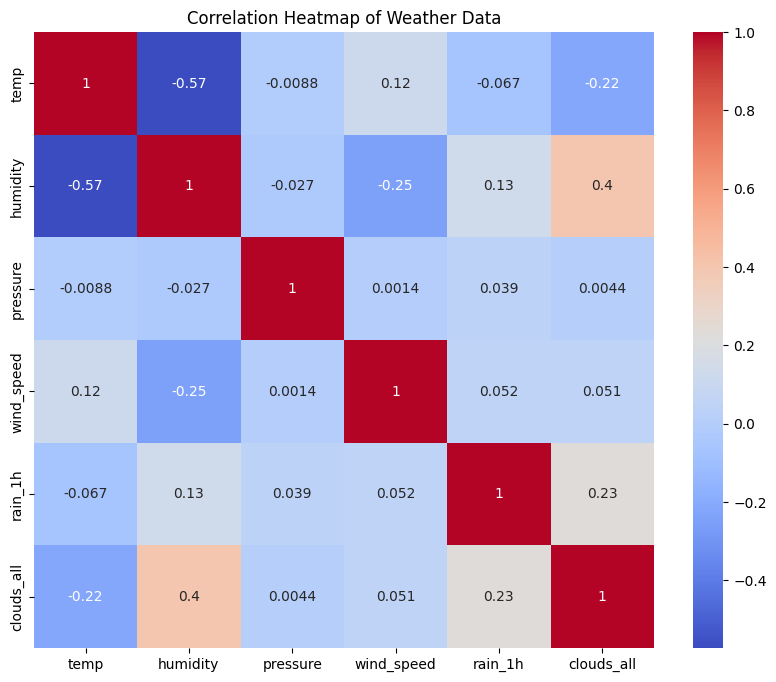

In [ ]:
plt.figure(figsize=(10,8))
corr_weather = df_weather[['temp', 'humidity', 'pressure', 'wind_speed', 'rain_1h', 'clouds_all']].corr()

sns.heatmap(corr_weather, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Weather Data')
plt.show()


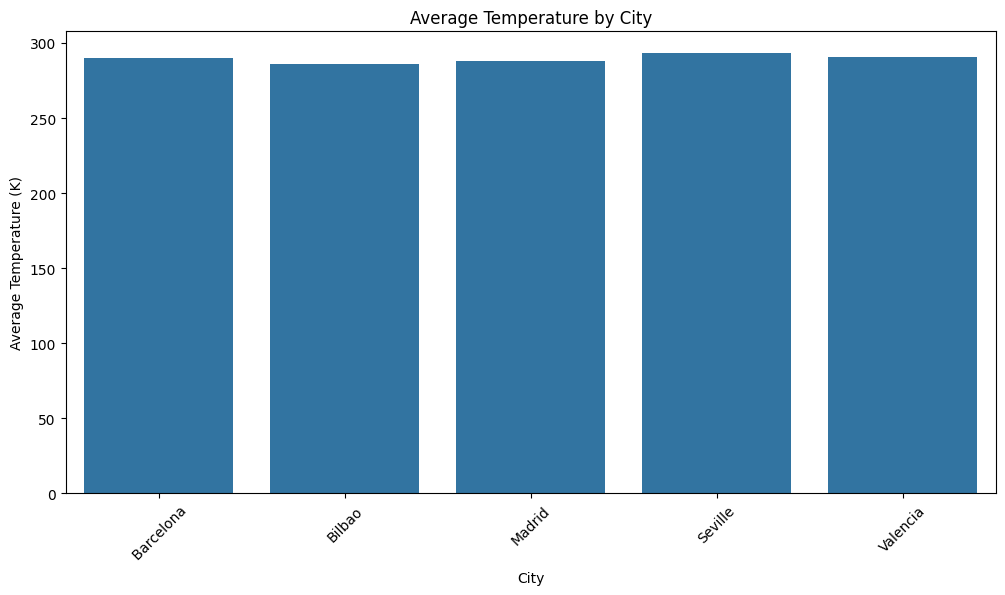

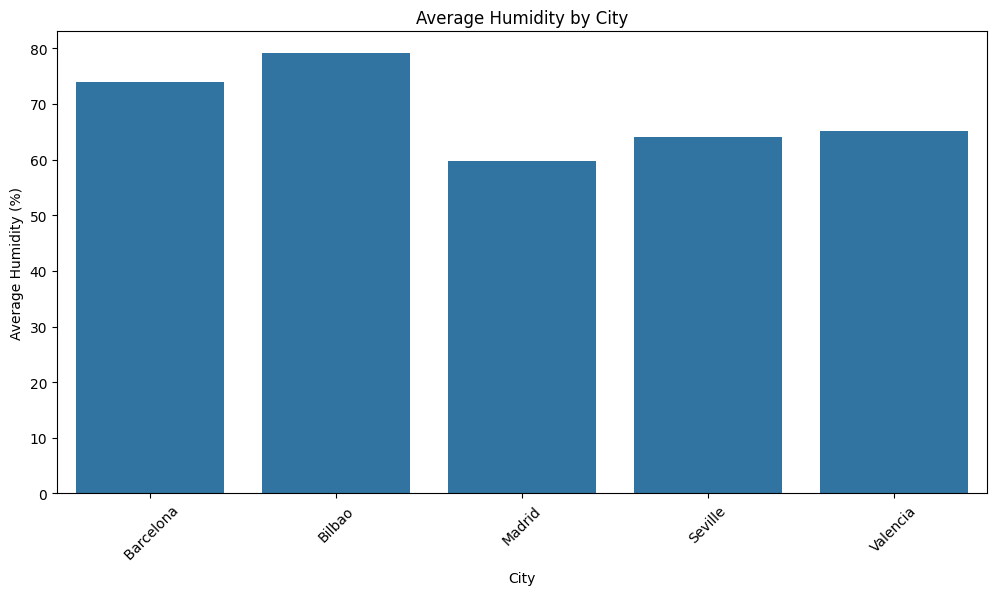

In [ ]:
# Group data by city and calculate average temperature and humidity
city_avg = df_weather.groupby('city_name')[['temp', 'humidity']].mean().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x='city_name', y='temp', data=city_avg)
plt.xlabel('City')
plt.ylabel('Average Temperature (K)')
plt.title('Average Temperature by City')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(x='city_name', y='humidity', data=city_avg)
plt.xlabel('City')
plt.ylabel('Average Humidity (%)')
plt.title('Average Humidity by City')
plt.xticks(rotation=45)
plt.show()


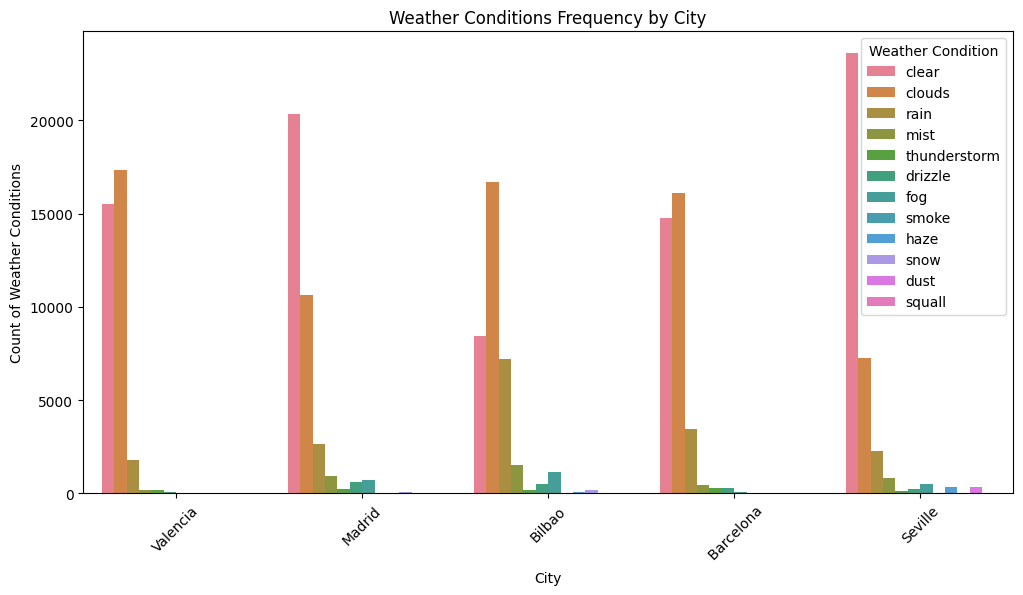

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(x='city_name', hue='weather_main', data=df_weather)
plt.xlabel('City')
plt.ylabel('Count of Weather Conditions')
plt.title('Weather Conditions Frequency by City')
plt.xticks(rotation=45)
plt.legend(title='Weather Condition')
plt.show()


We have to **split** the `df_weather` dataset into 5 datasets, **one for each different city** (Madrid, Barcelona, Bilbao, Seville and Valencia). But first, let's see the average values for each column, grouped by each city (note that the 'weather_id' average has no meaning whatsoever).

In [ ]:

mean_weather_by_city = df_weather.groupby('city_name').mean(numeric_only=True)
mean_weather_by_city

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
city_name,,,,,,,,,,,,
Barcelona,289.848248,288.594704,291.021987,1284.010486,73.994221,2.786588,187.188043,0.117079,0.000327,0.000000,23.229648,760.917465
Bilbao,286.378489,284.916661,288.036687,1017.567439,79.089455,1.957470,159.883536,0.123493,0.001034,0.023455,43.960697,723.943228
Madrid,288.061071,286.824877,289.155600,1011.838448,59.776932,2.441696,173.293159,0.055083,0.000129,0.000029,22.397028,762.260264
Seville,293.105431,291.184103,295.962431,1018.504711,64.140732,2.483787,151.757179,0.045392,0.000180,0.000000,14.748770,771.409849
Valencia,290.780780,290.222277,291.355025,1015.973794,65.145113,2.692815,160.753820,0.035924,0.000226,0.000154,20.820999,781.228283


In [ ]:
# Find NaNs and duplicates in df_weather

print(df_weather.isnull().values.sum())

temp_weather = df_weather.duplicated(keep='first').sum()

print(temp_weather)

0
8622


In [ ]:

# dropping duplicates  keeping only first appeared
df_weather = df_weather.reset_index().drop_duplicates(subset=['time', 'city_name'],
                                                      keep='first').set_index('time')

In [ ]:
# Drop columns
df_weather = df_weather.drop([ 'weather_id','weather_description', 'weather_icon',"rain_3h",'snow_3h'], axis=1)

In [ ]:
# Display the number of duplicates in df_weather

temp_weather = df_weather.reset_index().duplicated(subset=['time', 'city_name'],
                                                   keep='first').sum()
print('There are {} duplicate rows in df_weather ' \
      'based on all columns except "time" and "city_name".'.format(temp_weather))

There are 0 duplicate rows in df_weather based on all columns except "time" and "city_name".


# Handling Outliers

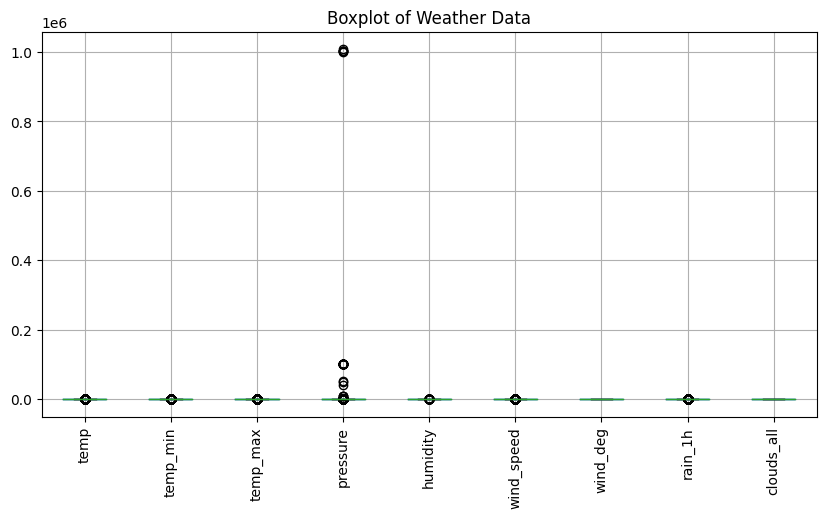

In [ ]:


# Boxplot for all columns in df_weather
plt.figure(figsize=(10, 5))
df_weather.boxplot()
plt.xticks(rotation=90)
plt.title('Boxplot of Weather Data')
plt.show()


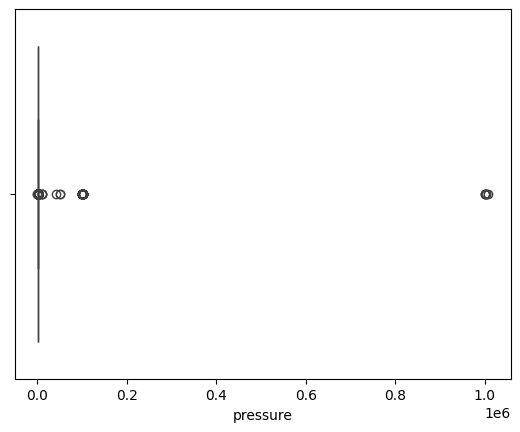

In [ ]:
# Check for outliers in 'pressure' column

sns.boxplot(x=df_weather['pressure'])
plt.show()

In [ ]:
# prompt: here in pressure column i wanna implement iqr and replace the values which are outliers with median

Q1 = df_weather['pressure'].quantile(0.25)
Q3 = df_weather['pressure'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

median_pressure = df_weather['pressure'].median()

df_weather['pressure'] = np.where((df_weather['pressure'] < lower_bound) | (df_weather['pressure'] > upper_bound),
                                 median_pressure, df_weather['pressure'])


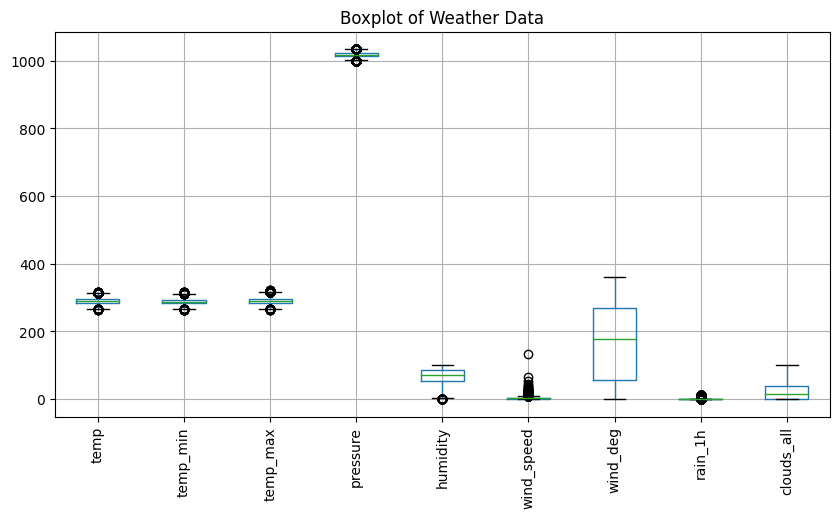

In [ ]:
# Boxplot for all columns in df_weather
plt.figure(figsize=(10, 5))
df_weather.boxplot()
plt.xticks(rotation=90)
plt.title('Boxplot of Weather Data')
plt.show()

i see still there are some outliers in wind_speed column

In [ ]:
Q1 = df_weather['wind_speed'].quantile(0.25)
Q3 = df_weather['wind_speed'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

median_wind = df_weather['wind_speed'].median()

df_weather['wind_speed'] = np.where((df_weather['wind_speed'] < lower_bound) | (df_weather['wind_speed'] > upper_bound),
                                 median_wind, df_weather['wind_speed'])

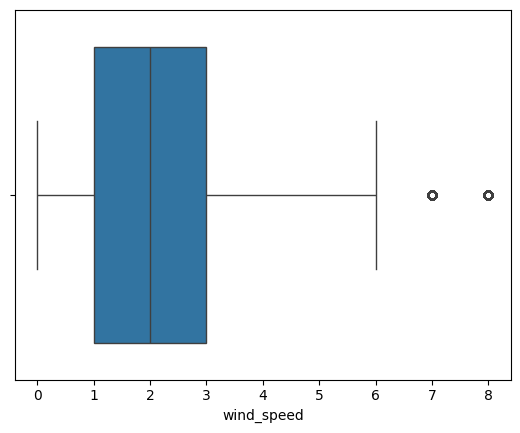

In [ ]:
# Check for outliers in 'wind_speed' column

sns.boxplot(x=df_weather['wind_speed'])
plt.show()

## * One Hot Encoding

In [ ]:

# encoding weather_main column
weather_main_encoded = pd.get_dummies(df_weather['weather_main'], prefix='weather_main')
df_weather = pd.concat([df_weather, weather_main_encoded], axis=1)
df_weather = df_weather.drop('weather_main', axis=1)


# merging datasets

In [ ]:
# Split the df_weather into 5 dataframes (one for each city)

df_1, df_2, df_3, df_4, df_5 = [x for _, x in df_weather.groupby('city_name')]
dfs = [df_1, df_2, df_3, df_4, df_5]

In [ ]:
# Merge all dataframes into the final dataframe

df_final = df_energy

for df in dfs:
    city = df['city_name'].unique()
    city_str = str(city).replace("'", "").replace('[', '').replace(']', '').replace(' ', '')
    df = df.add_suffix('_{}'.format(city_str))
    df_final = df_final.merge(df, on=['time'], how='outer')
    df_final = df_final.drop('city_name_{}'.format(city_str), axis=1)

df_final.columns

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other',
       ...
       'weather_main_drizzle_Valencia', 'weather_main_dust_Valencia',
       'weather_main_fog_Valencia', 'weather_main_haze_Valencia',
       'weather_main_mist_Valencia', 'weather_main_rain_Valencia',
       'weather_main_smoke_Valencia', 'weather_main_snow_Valencia',
       'weather_main_squall_Valencia', 'weather_main_thunderstorm_Valencia'],
      dtype='object', length=122)

In [ ]:
# Display the number of NaNs and duplicates in the final dataframe

print('There are {} missing values or NaNs in df_final.'
      .format(df_final.isnull().values.sum()))

temp_final = df_final.duplicated(keep='first').sum()

print('\nThere are {} duplicate rows in df_energy based on all columns.'
      .format(temp_final))

There are 0 missing values or NaNs in df_final.

There are 0 duplicate rows in df_energy based on all columns.


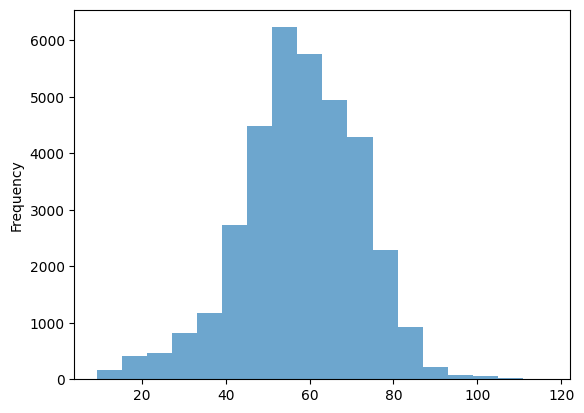

In [ ]:
# Plot the histogram of the actual electricity price

ax = df_final['price actual'].plot.hist(bins=18, alpha=0.65)

In [ ]:
# Generate 'hour', 'weekday' and 'month' features

for i in range(len(df_final)):
    position = df_final.index[i]
    hour = position.hour
    weekday = position.weekday()
    month = position.month
    df_final.loc[position, 'hour'] = hour
    df_final.loc[position, 'weekday'] = weekday
    df_final.loc[position, 'month'] = month

In [ ]:
# Function to generate training data for a multivariate time series forecasting model.
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

In [ ]:
# (rows and columns count)
df_final.shape

(35064, 125)

In [ ]:
#splitting data and this below mentioned numbers are  range of row len
train_end_idx = 27048
cv_end_idx = 31056
test_end_idx = 35063

In [ ]:
X = df_final[df_final.columns.drop('price actual')].values # price actualis our target variable
y = df_final['price actual'].values

y = y.reshape(-1, 1)

# normalizing

In [ ]:
# Initialize two MinMaxScalers to scale the input features and target variable.
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

In [ ]:
# fitting minmax scaler
scaler_X.fit(X[:train_end_idx])
scaler_y.fit(y[:train_end_idx])

MinMaxScaler()

In [ ]:
# Normalize the input features (X) and target variable (y) using the previously defined scaler.
X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(y)

# Dimensionality reduction

In [ ]:
# Initialize PCA (Principal Component Analysis) for dimensionality reduction.
pca = PCA()  # Create an instance of PCA without specifying the number of components (it will keep all components by default).

# Fit PCA on the normalized training data (up to train_end_idx) to learn the principal components.
X_pca = pca.fit(X_norm[:train_end_idx])  # Fit the PCA model on the normalized input features up to the training end index.

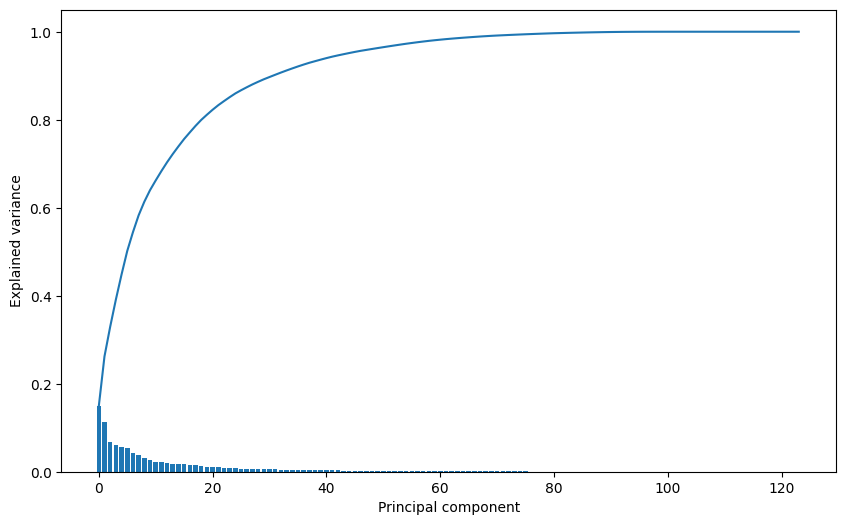

In [ ]:
# plot of pca
num_components = len(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.bar(np.arange(num_components), pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Principal component')
plt.ylabel('Explained variance')
plt.show()

In [ ]:
# Initialize PCA with a specified number of components to retain 75% of the variance.
pca = PCA(n_components=0.75)

# Fit PCA on the normalized training data (up to train_end_idx) to learn the principal components.
pca.fit(X_norm[:train_end_idx])

# Transform the entire normalized dataset (X_norm) into the reduced dimensionality space using the fitted PCA model.
X_pca = pca.transform(X_norm)

In [ ]:
# Combine the PCA-reduced features and the normalized target variable into a single dataset.
dataset_norm = np.concatenate((X_pca, y_norm), axis=1)  # Concatenate the PCA features and the normalized target along the columns.

# Define parameters for the time series data preparation.
past_history = 24  # The number of past timesteps to consider for each input sequence.
future_target = 1  # The number of future timesteps to predict. Here, it is set to 0, indicating we want the immediate next value.

# Calculate the index for the end of the test dataset based on the length of the normalized target.
test_end_idx = len(y_norm) - past_history - future_target  # This ensures enough data for creating input sequences.


In [ ]:

# Define the past history and future target
past_history = 24
future_target = 1
STEP = 1

# Create training, cv, and test datasets
x_train_multi, y_train_multi = multivariate_data(X_pca, y_norm, 0, train_end_idx, past_history,
                                                   future_target, STEP, single_step=True)
x_cv_multi, y_cv_multi = multivariate_data(X_pca, y_norm, train_end_idx, cv_end_idx, past_history,
                                               future_target, STEP, single_step=True)
x_test_multi, y_test_multi = multivariate_data(X_pca, y_norm, cv_end_idx, test_end_idx, past_history,
                                                 future_target, STEP, single_step=True)
# Build the LSTM model
model = tf.keras.models.Sequential([
    LSTM(128, return_sequences=True, input_shape=x_train_multi.shape[-2:]),  # Increased units and return sequences for the next LSTM layer
    Dropout(0.2),  # Add dropout to reduce overfitting
    LSTM(64, return_sequences=True),  # Added a second LSTM layer with reduced units
    Dropout(0.2),  # Add dropout to further reduce overfitting
    LSTM(32),  # A third LSTM layer for capturing more complex patterns
    Dropout(0.2),  # Another dropout layer
    Dense(1)  # Output layer for regression (predicting a single value)
])


from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(x_train_multi, y_train_multi, epochs=20, batch_size=32, validation_data=(x_cv_multi, y_cv_multi),callbacks=[early_stopping])

# Evaluate the model on the test data
y_pred_multi = model.predict(x_test_multi)

# Inverse transform the predictions and actual values
y_pred_multi = scaler_y.inverse_transform(y_pred_multi)
y_test_multi = scaler_y.inverse_transform(y_test_multi)

# Calculate RMSE and R-squared
rmse = sqrt(mean_squared_error(y_test_multi, y_pred_multi))
r2 = r2_score(y_test_multi, y_pred_multi)

print('RMSE:', rmse)
print('R-squared:', r2)


Epoch 1/20
845/845 ━━━━━━━━━━━━━━━━━━━━ 58s 61ms/step - loss: 0.0197 - val_loss: 0.0153
Epoch 2/20
845/845 ━━━━━━━━━━━━━━━━━━━━ 82s 61ms/step - loss: 0.0080 - val_loss: 0.0134
Epoch 3/20
845/845 ━━━━━━━━━━━━━━━━━━━━ 50s 59ms/step - loss: 0.0055 - val_loss: 0.0152
Epoch 4/20
845/845 ━━━━━━━━━━━━━━━━━━━━ 84s 61ms/step - loss: 0.0042 - val_loss: 0.0148
Epoch 5/20
845/845 ━━━━━━━━━━━━━━━━━━━━ 82s 61ms/step - loss: 0.0032 - val_loss: 0.0149
Epoch 6/20
845/845 ━━━━━━━━━━━━━━━━━━━━ 51s 60ms/step - loss: 0.0024 - val_loss: 0.0150
Epoch 7/20
845/845 ━━━━━━━━━━━━━━━━━━━━ 52s 61ms/step - loss: 0.0021 - val_loss: 0.0172
Epoch 8/20
845/845 ━━━━━━━━━━━━━━━━━━━━ 80s 59ms/step - loss: 0.0018 - val_loss: 0.0155
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
RMSE: 14.80969589739103
R-squared: -2.2029797728902225


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


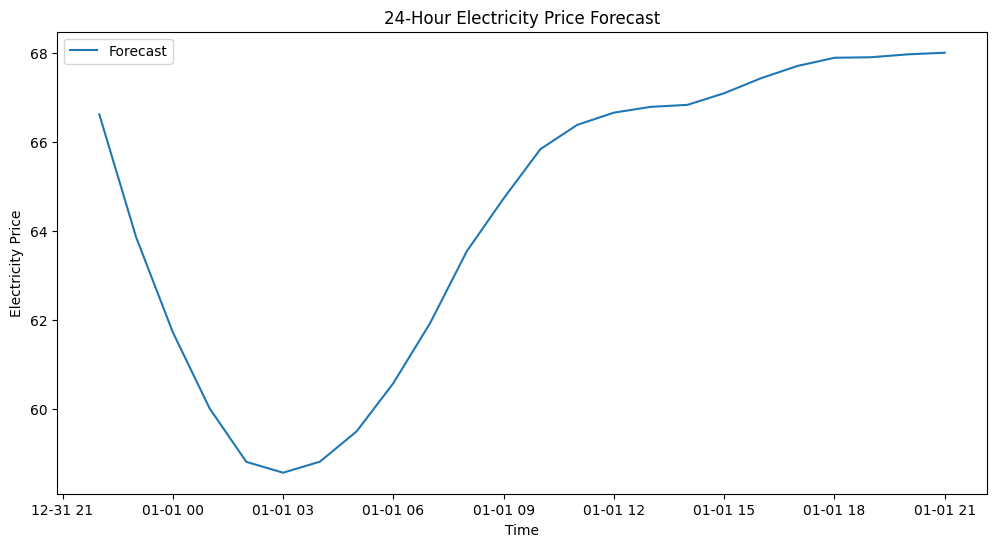

In [ ]:
# Get the last  hours of data from the test set
last_hours = x_test_multi[-50:]
# Create an empty list to store the forecasted values
forecasted_values = []

# Loop through the next 24 hours
for i in range(24):
  # Predict the next hour's value
  next_hour_prediction = model.predict(last_hours)

  # Append the prediction to the forecasted values list
  forecasted_values.append(next_hour_prediction[0][0])

  # Update the last 24 hours with the new prediction
  last_hours = np.roll(last_hours, -1, axis=1)
  last_hours[0][-1] = next_hour_prediction[0]


# Inverse transform the forecasted values
forecasted_values = scaler_y.inverse_transform(np.array(forecasted_values).reshape(-1, 1))

# Create a time series for the next 24 hours
forecast_time_series = pd.date_range(start=df_final.index[-1], periods=24, freq='H')

# Plot the forecasted values
plt.figure(figsize=(12, 6))
plt.plot(forecast_time_series, forecasted_values, label='Forecast')
plt.xlabel('Time')
plt.ylabel('Electricity Price')
plt.title('24-Hour Electricity Price Forecast')
plt.legend()
plt.show()